In [1]:
try:
    # if this notebook is being called by another one
    # used passed gene_name value
    gene_name
except:
    # otherwise, set value to amacGFP / avGFP / cgreGFP / ppluGFP,
    # for instance for debugging here
    gene_name="avGFP"



In [69]:

def test_plot(y_true_,y_pred_):
    r2 = r2_score(y_true_, y_pred_)

    # Create scatter plot
    plt.figure(figsize=(10, 8))
    # plt.scatter(y_true_, y_pred_, color='blue', label='Data points')

    hb = plt.hexbin(y_true_, y_pred_, gridsize=50, cmap='coolwarm', bins='log')
    cb = plt.colorbar(hb)
    cb.set_label('log10(N)')


    #plot ideal 
    plt.plot([min(y_true_), max(y_true_)], [min(y_true_), max(y_true_)], color='red', linestyle='--', label='Ideal fit')
    plt.xlabel('Target')
    plt.ylabel('Predicted')
    plt.title('Scatter Plot of True vs. Predicted Values')
    plt.text(x=min(y_true_), y=max(y_pred_), s=f'\n\n    R² = {r2:.2f}', fontsize=15, verticalalignment='top')
    plt.legend()
    plt.grid(True)
    plt.show()

def history_plot(history):
    import matplotlib.pyplot as plt

    # Plot training & validation loss values
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation MAE values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mean_absolute_error'])
    plt.plot(history.history['val_mean_absolute_error'])
    plt.title('Model MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

def append_history(history, new_history):
    for key in history.history.keys():
        history.history[key].extend(new_history.history[key])

In [3]:
recompute=False
recompute_ESM=False
# True: retrain all models
# False: try loading saved models, otherwise retrain models

Import modules
Define functions
Load avGFP data
avGFP 239 aa


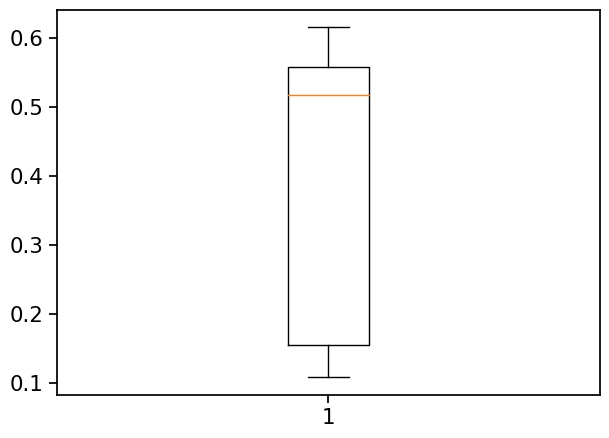

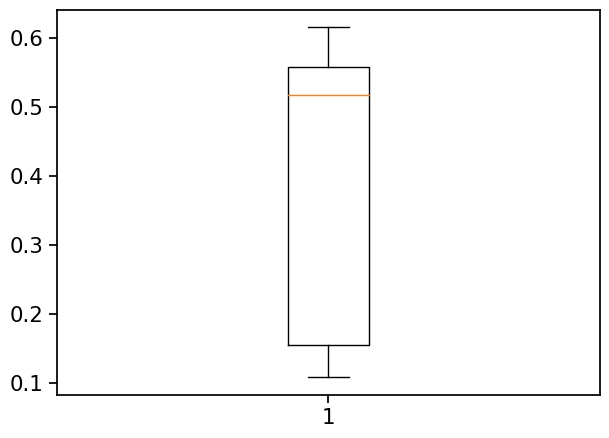

Pre-processing avGFP
Load avGFP encodings
Split train, valid, test sets
train_index 31029
valid_index 10343
test_index 10343


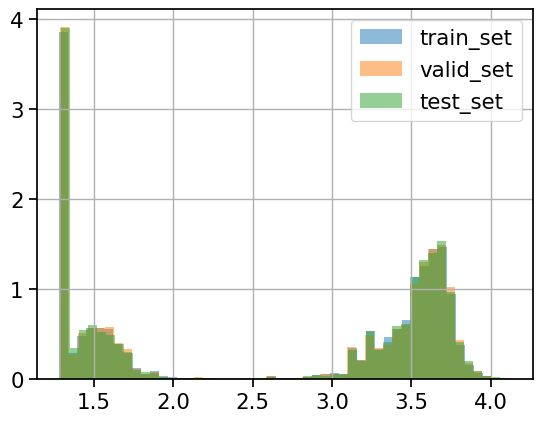

In [4]:
showmatrix=False
threshold_df = ''
%run 01_preprocessing.ipynb

In [5]:
# create folder for saving figures and data of figures
try:mkdir("_transformers_Figures/")
except:pass

In [50]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K



# using ESM embeddings

In [7]:
recompute_ESM=False
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
# from preprocessing import *

from sklearn.svm import SVC, SVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, train_test_split
# from src.kneighborRegressor import *
# from src.regression_grids import *

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [8]:
if recompute_ESM:
    # Function to load the ESM model
    def load_esm_model(model_name, device='cpu'):
        repr_layer = int(model_name.split('_')[1][1:])
        model, alphabet = torch.hub.load("facebookresearch/esm:main", model_name)
        batch_converter = alphabet.get_batch_converter()
        return model.eval().to(device), alphabet, batch_converter, repr_layer

    # Load the model
    model, alphabet, batch_converter, repr_layer = load_esm_model(model_name='esm2_t33_650M_UR50D', device='cpu')

    genes = df_["aaMutations"]
    device = "cpu"

    # Initialize an empty DataFrame to store predictors
    predictors = pd.DataFrame()

    for idx, gene in enumerate(genes):
        # Directly access the sequence associated with the gene
        sequence = df_.loc[df_["aaMutations"] == gene, "full_seq"].iloc[0][:-1]  # Remove final stop codon
        dt = [(gene, sequence)]
        batch_labels, batch_strs, batch_tokens = batch_converter(dt)
        
        with torch.no_grad():
            results_ = model(batch_tokens.to(device), repr_layers=[repr_layer], return_contacts=True)['representations'][repr_layer]
        
        # Compute features for this gene
        features = results_.mean(dim=1).cpu().numpy()  # Averages across the sequence_length dimension
        # features_2d = features.mean(axis=1)  # Further reduce to a single dimension per sample
        
        # Update predictors DataFrame for this gene
        gene_predictors = pd.DataFrame(features.reshape(1, -1), index=[gene])
        predictors = pd.concat([predictors, gene_predictors])
        
        # Save to CSV on each iteration (this updates the CSV file with new data)
        

        # # Optional print to monitor progress
        # if idx % 100 == 0:  # Print status every 100 genes processed
        #     print(f'Processed {idx+1} genes out of {len(genes)}')
    predictors.to_csv(r'D:\Bea\avGFP_ESMpredictors_total.csv')
    # Print final shape of predictors DataFrame
    print(predictors.shape)


In [ ]:

# df1= pd.read_csv(r'D:\Bea\avGFP_ESMpredictors.csv')
# df2 = pd.read_csv(r'D:\Bea\avGFP_ESMpredictors_2.csv')
# df3 = pd.concat([df1, df2])
# df3.reset_index(inplace=True, drop=True)
# df3.index = df3.iloc[:,0].values
# df3=df3.drop(columns='Unnamed: 0')
# df3.to_csv(r'D:\Bea\avGFP_ESMpredictors_total.csv')

In [25]:
predictors=pd.read_csv(r'D:\Bea\avGFP_ESMpredictors_total.csv')
predictors.reset_index(inplace=True, drop=True)
predictors.drop(columns='Unnamed: 0',inplace=True)

In [26]:
predictors

,aaMutations,0,1,2,3,4,5,6,7,8,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,wt,0.004420,-0.010806,-0.039352,-0.004249,-0.080919,-0.018824,-0.039308,0.020152,0.049724,...,0.146634,0.047349,0.014803,0.077491,-0.012645,0.109253,0.081489,0.014164,-0.013374,-0.009202
1,A109D,0.013414,0.005480,-0.024966,0.007041,-0.084338,-0.009175,-0.039329,0.009769,0.067250,...,0.145429,0.039966,0.014756,0.081403,-0.024934,0.104580,0.060403,0.008134,0.007964,-0.018587
2,A109D:N145D:I187V:M232T:L235P,-0.004498,-0.004762,-0.049193,-0.009528,-0.094472,-0.007792,-0.029339,0.011535,0.064937,...,0.165463,0.051789,0.012113,0.093974,-0.016039,0.118000,0.074705,-0.010761,0.002410,-0.020724
3,A109D:Y142N:H147L:E221G,0.013743,-0.003611,-0.027229,0.010028,-0.089830,-0.005264,-0.040026,0.018508,0.080657,...,0.145503,0.045153,0.018398,0.083854,-0.021423,0.105398,0.059490,0.002479,-0.010287,-0.010422
4,A109G,0.009904,-0.006905,-0.031065,-0.005074,-0.083564,-0.018463,-0.039464,0.011883,0.059924,...,0.144673,0.044404,0.014219,0.076938,-0.020277,0.108153,0.072625,0.016760,-0.005951,-0.009509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51710,Y91N:N104S:I170F,0.005575,-0.009617,-0.034236,-0.001236,-0.086473,-0.019616,-0.032684,0.020444,0.062518,...,0.145129,0.052969,0.015034,0.089065,-0.015429,0.100679,0.070732,0.017503,-0.011338,-0.009888
51711,Y91N:Q176L:L206Q:T229A:M232V,0.003160,-0.014020,-0.038566,-0.000342,-0.086004,-0.016294,-0.040385,0.016038,0.051165,...,0.147561,0.048063,0.013059,0.077378,-0.008303,0.090519,0.077944,0.012362,-0.017925,-0.000320
51712,Y91R:I151N:N197S,0.011072,-0.009971,-0.038365,-0.003960,-0.073947,-0.022506,-0.032816,0.012826,0.059133,...,0.150429,0.053323,0.017938,0.082343,-0.027753,0.106819,0.076847,0.012376,-0.005664,-0.010424
51713,Y91R:I166T:L235P,-0.008275,-0.010086,-0.051515,-0.021569,-0.091886,-0.028355,-0.030329,0.026899,0.064264,...,0.157627,0.057820,0.007733,0.093188,-0.005243,0.112241,0.086058,0.011568,-0.016701,-0.015416


In [27]:
target.reset_index(inplace=True,drop=True)

In [28]:
df.reset_index(inplace=True,drop=True)
df

,aaMutations,medianBrightness,aa_genotype_pseudo,full_seq
0,wt,3.719212,wt,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
1,A109D,1.301030,A113D,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
2,A109D:N145D:I187V:M232T:L235P,1.301031,A113D:N149D:I191V:M240T:L243P,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
3,A109D:Y142N:H147L:E221G,1.301189,A113D:Y146N:H151L:E229G,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
4,A109G,3.708478,A113G,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
...,...,...,...,...
51710,Y91N:N104S:I170F,1.552090,Y95N:N108S:I174F,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
51711,Y91N:Q176L:L206Q:T229A:M232V,1.301030,Y95N:Q180L:L213Q:T237A:M240V,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
51712,Y91R:I151N:N197S,1.301030,Y95R:I155N:N204S,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
51713,Y91R:I166T:L235P,1.301517,Y95R:I170T:L243P,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...


In [29]:
l2 = list(predictors['aaMutations'])
l1=list(df['aaMutations'])
for i in range(len(l2)):
    if l1[i]==l2[i]:
        pass
    else:
        print(i)
        print(l1[i], l2[i])
        
l1==l2
if l1==l2:
    predictors.drop(['aaMutations'],axis=1,inplace=True)

Split train, valid, test sets
train_index 31029
valid_index 10343
test_index 10343


<Axes: >

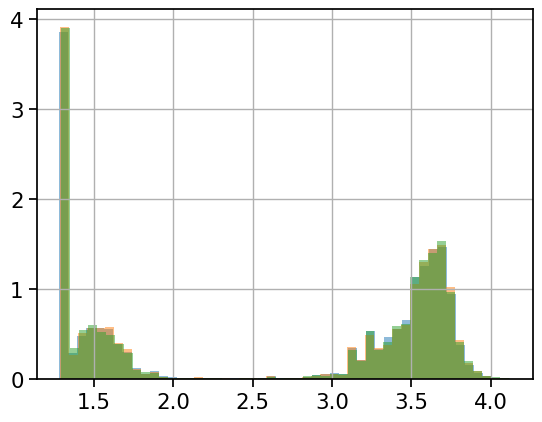

In [31]:
# First split train, valid, test indexes (not very elegant, yes)
print("Split train, valid, test sets")

(predictors_train,
predictors_valid_test, 
target_train, 
target_valid_test) = train_test_split(df.index, 
                                    df.index, 
                                    test_size=0.4, 
                                    random_state=42)

(predictors_valid, 
predictors_test, 
target_valid,
target_test) = train_test_split(predictors_valid_test, 
                            target_valid_test, 
                            test_size=0.5, 
                            random_state=42)

train_index = sorted(predictors_train)
valid_index = sorted(predictors_valid)
test_index  = sorted(predictors_test)

    
predictors_train = predictors.loc[train_index]
predictors_valid = predictors.loc[valid_index]
predictors_test = predictors.loc[test_index]

target_train = target.loc[train_index]
target_valid = target.loc[valid_index]
target_test = target.loc[test_index]

print("train_index",len(train_index))
print("valid_index",len(valid_index))
print("test_index",len(test_index))

#------------------------------------------------------------
# check subset sizes and medianBrightness distributions (using density parameter)
fig, ax = plt.subplots()
fig.patch.set_facecolor('w')

target_train[brightness_col].hist(alpha=0.5, density=True, bins=50)
target_valid[brightness_col].hist(alpha=0.5, density=True, bins=50)
target_test[brightness_col].hist(alpha=0.5, density=True, bins=50)


In [49]:
def build_model(embedding_dim, num_labels):
    # Input layer that accepts embeddings directly
    input_layer = Input(shape=(embedding_dim,))

    # Adding a few dense layers for processing
    x = Dense(512, activation='relu')(input_layer)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    # Prediction layer
    output_layer = Dense(num_labels, activation='linear')(x)  # Use sigmoid for binary classification/regression

    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer)
    return model


In [53]:
del model
K.clear_session()  
# Define model parameters
embedding_dim = len(predictors_train.columns)  # Example embedding dimension
num_labels = 1       # Number of output labels; change as needed

# Create the model
model = build_model(embedding_dim, num_labels)

# Compile the model
model.compile(optimizer='adam',
              loss='mean_squared_error',  # Use 'categorical_crossentropy' for multi-label classification
              metrics=['mean_absolute_error'])


In [54]:
# Train the model
history = model.fit(predictors_train.values, 
          target_train.values.ravel(), 
          epochs=100, 
          batch_size=32, 
          validation_data=(predictors_valid.values, target_valid.values.ravel()))


Epoch 1/100
970/970 [==============================] - 4s 4ms/step - loss: 1.1060 - mean_absolute_error: 0.9001 - val_loss: 0.8230 - val_mean_absolute_error: 0.8270
Epoch 2/100
970/970 [==============================] - 3s 4ms/step - loss: 0.9457 - mean_absolute_error: 0.8526 - val_loss: 0.8602 - val_mean_absolute_error: 0.8710
Epoch 3/100
970/970 [==============================] - 3s 4ms/step - loss: 0.9930 - mean_absolute_error: 0.9050 - val_loss: 0.9026 - val_mean_absolute_error: 0.9150
Epoch 4/100
970/970 [==============================] - 3s 4ms/step - loss: 0.9477 - mean_absolute_error: 0.8693 - val_loss: 0.8385 - val_mean_absolute_error: 0.8548
Epoch 5/100
970/970 [==============================] - 3s 4ms/step - loss: 0.9709 - mean_absolute_error: 0.8888 - val_loss: 0.7970 - val_mean_absolute_error: 0.8425
Epoch 6/100
970/970 [==============================] - 3s 4ms/step - loss: 0.9592 - mean_absolute_error: 0.8763 - val_loss: 0.7717 - val_mean_absolute_error: 0.7975
Epoch 7/10

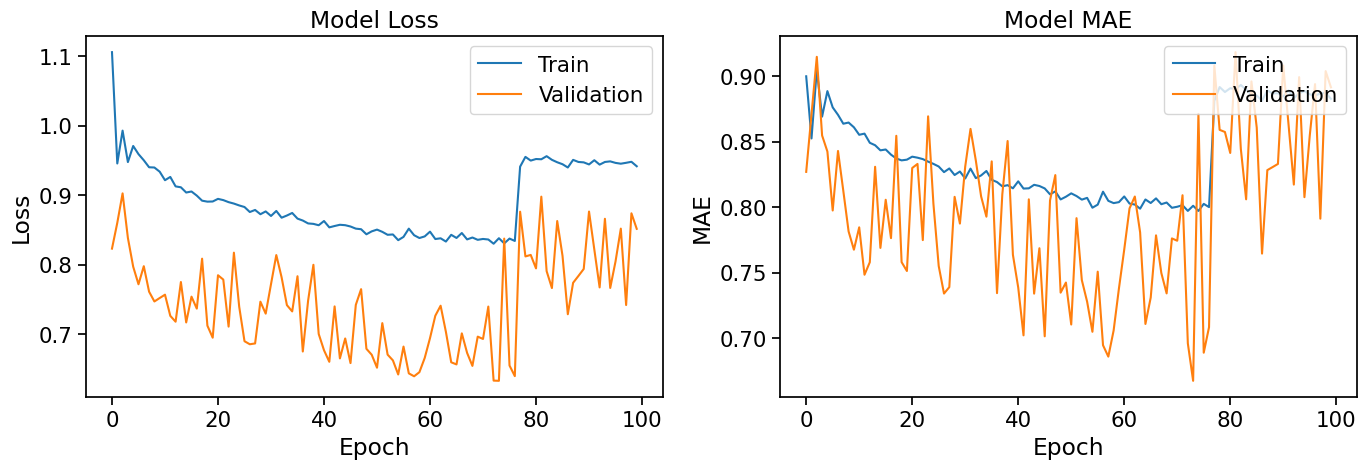

In [55]:
history_plot(history)

In [56]:

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(predictors_test.values, target_test.values.ravel())
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
y_pred=model.predict(predictors_test)


324/324 [==============================] - 1s 2ms/step - loss: 0.8518 - mean_absolute_error: 0.8912
Test Loss: 0.8518098592758179
Test Accuracy: 0.8911632895469666
324/324 [==============================] - 0s 1ms/step


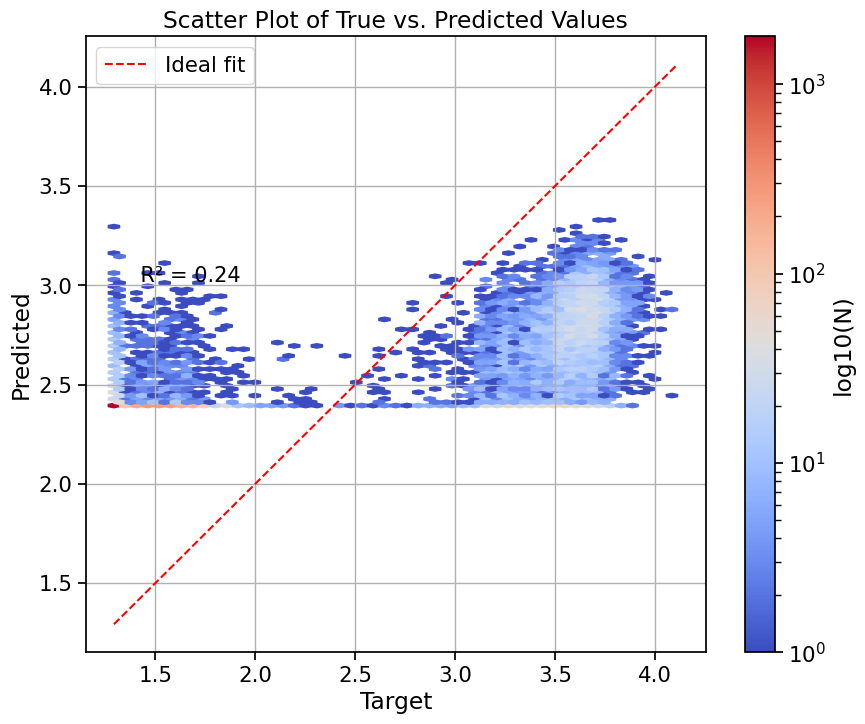

In [57]:
y_pred_ = y_pred.ravel()
y_true_ = target_test.values.ravel()


test_plot(y_true_,y_pred_)

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

## ARCH 4
def build_model(input_length):
    model = Sequential([
        # Convolutional Layer
        Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(input_length, 1)),
        MaxPooling1D(pool_size=2),
        # Additional Convolutional Layers
        Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
        MaxPooling1D(pool_size=2),
        # Flatten the output of the conv layers to feed into dense layer
        Flatten(),
        # Dense Layer for prediction
        Dense(128, activation='relu'),
        # Output layer for regression
        Dense(1, activation='linear')
    ])
    
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    return model


In [61]:
import numpy as np
del model
K.clear_session()  
input_length = len(predictors_train.values[0])
# Example of using the model
model = build_model(input_length)  
# Train the model
history = model.fit(predictors_train.values, 
          target_train.values.ravel(), 
          epochs=100, 
          batch_size=32, 
          validation_data=(predictors_valid.values, target_valid.values.ravel()))

Epoch 1/100
970/970 [==============================] - 9s 7ms/step - loss: 0.8924 - mean_absolute_error: 0.8274 - val_loss: 0.6914 - val_mean_absolute_error: 0.6879
Epoch 2/100
970/970 [==============================] - 7s 7ms/step - loss: 0.7086 - mean_absolute_error: 0.6960 - val_loss: 0.7728 - val_mean_absolute_error: 0.6536
Epoch 3/100
970/970 [==============================] - 7s 7ms/step - loss: 0.6570 - mean_absolute_error: 0.6582 - val_loss: 0.6875 - val_mean_absolute_error: 0.6129
Epoch 4/100
970/970 [==============================] - 7s 7ms/step - loss: 0.6212 - mean_absolute_error: 0.6300 - val_loss: 0.5664 - val_mean_absolute_error: 0.5933
Epoch 5/100
970/970 [==============================] - 7s 7ms/step - loss: 0.5880 - mean_absolute_error: 0.6055 - val_loss: 0.6199 - val_mean_absolute_error: 0.6601
Epoch 6/100
970/970 [==============================] - 6s 7ms/step - loss: 0.5701 - mean_absolute_error: 0.5919 - val_loss: 0.5346 - val_mean_absolute_error: 0.5801
Epoch 7/10

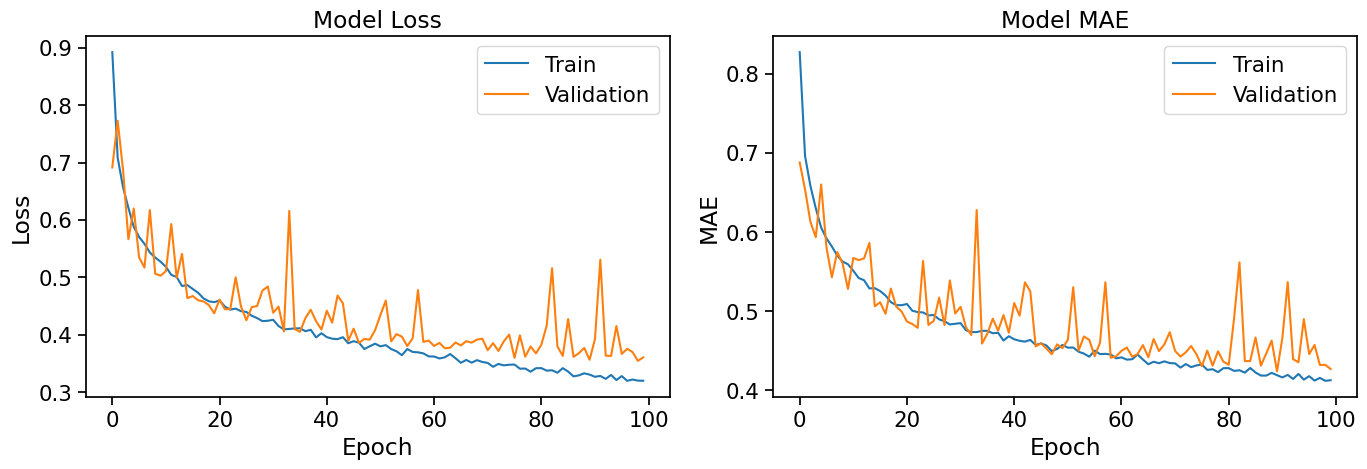

In [62]:
history_plot(history)

In [70]:
new_history = model.fit(predictors_train.values, 
                        target_train.values.ravel(), 
                        epochs=50,  # Additional epochs
                        batch_size=32,
                        validation_data=(predictors_valid.values, 
                                         target_valid.values.ravel()))
append_history(history, new_history)

Epoch 1/50
970/970 [==============================] - 7s 7ms/step - loss: 0.3152 - mean_absolute_error: 0.4099 - val_loss: 0.3634 - val_mean_absolute_error: 0.4269
Epoch 2/50
970/970 [==============================] - 7s 7ms/step - loss: 0.3214 - mean_absolute_error: 0.4143 - val_loss: 0.4236 - val_mean_absolute_error: 0.4645
Epoch 3/50
970/970 [==============================] - 6s 7ms/step - loss: 0.3098 - mean_absolute_error: 0.4052 - val_loss: 0.4156 - val_mean_absolute_error: 0.4945
Epoch 4/50
970/970 [==============================] - 7s 7ms/step - loss: 0.3147 - mean_absolute_error: 0.4090 - val_loss: 0.3568 - val_mean_absolute_error: 0.4291
Epoch 5/50
970/970 [==============================] - 7s 7ms/step - loss: 0.3115 - mean_absolute_error: 0.4077 - val_loss: 0.3655 - val_mean_absolute_error: 0.4303
Epoch 6/50
970/970 [==============================] - 7s 7ms/step - loss: 0.3103 - mean_absolute_error: 0.4067 - val_loss: 0.3552 - val_mean_absolute_error: 0.4323
Epoch 7/50
970/9

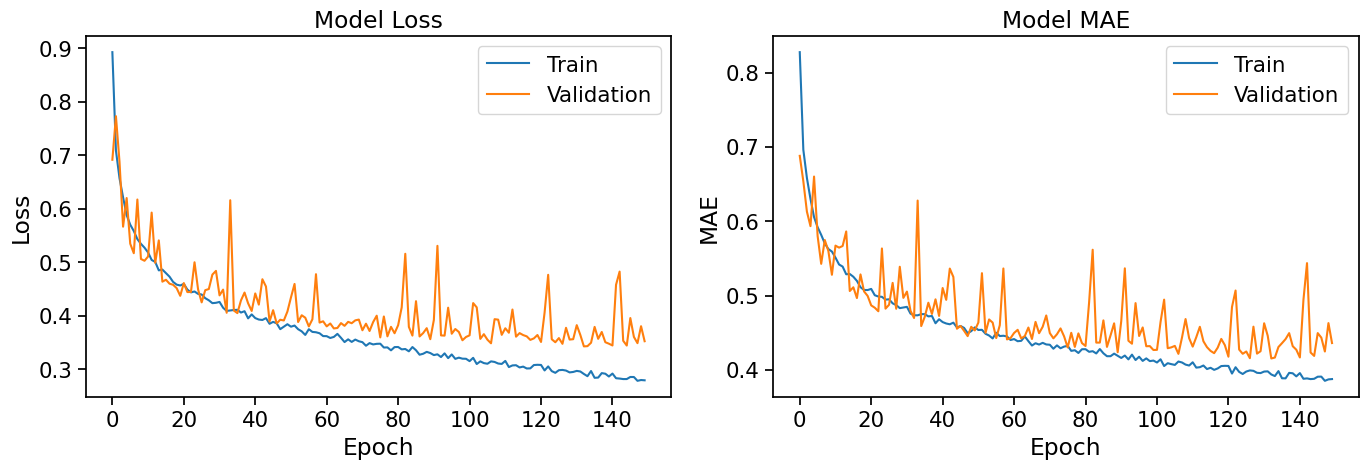

In [71]:
history_plot(history)

In [72]:

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(predictors_test.values, target_test.values.ravel())
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
y_pred=model.predict(predictors_test.values)


324/324 [==============================] - 1s 3ms/step - loss: 0.3549 - mean_absolute_error: 0.4331
Test Loss: 0.35491907596588135
Test Accuracy: 0.43313536047935486
324/324 [==============================] - 1s 2ms/step


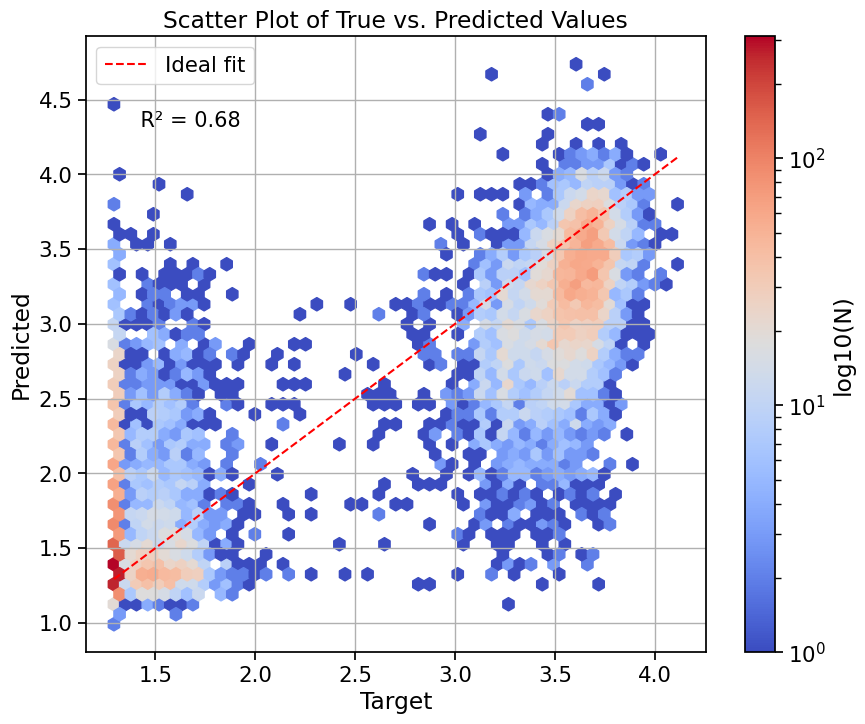

In [73]:

y_pred_ = y_pred.ravel()
y_true_ = target_test.values.ravel()
test_plot(y_true_,y_pred_)

# using one-hot encoding 

In [ ]:
X_train_flat = predictors_train.values
# Reshape the flat array to (238, 20) per sample
num_samples = X_train_flat.shape[0]
X_train = X_train_flat.reshape(num_samples, 239, 20)

y_train = target_train.values.ravel()


#test re shape
X_test_flat = predictors_test.values
# Reshape the flat array to (238, 20) per sample
num_samples = X_test_flat.shape[0]
X_test = X_test_flat.reshape(num_samples, 239, 20)

y_test = target_test.values.ravel()

#valid re shape
X_val_flat = predictors_valid.values
# Reshape the flat array to (238, 20) per sample
num_samples = X_val_flat.shape[0]
X_val = X_val_flat.reshape(num_samples, 239, 20)

y_val = target_valid.values.ravel()


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

##ARCH 1
def build_model(input_shape):
    model = Sequential([
        # Convolutional Layer
        Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        # You can add more convolutional and pooling layers here
        Flatten(),
        # Dense Layer for prediction
        Dense(128, activation='relu'),
        Dropout(0.5),  # Dropout added to prevent overfitting
        # Output layer for regression
        Dense(1, activation='linear')
    ])
    
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    return model


In [ ]:
### ARCH 2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

def build_model(input_shape):
    model = Sequential([
        # First Convolutional Layer
        Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        
        # Second Convolutional Layer
        Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
        MaxPooling1D(pool_size=2),
        
        # Optionally add more layers...
        
        # Flatten the output of the conv layers to feed into dense layer
        Flatten(),
        
        # Dense Layer for prediction with Dropout for regularization
        Dense(128, activation='relu'),
        Dropout(0.5),  # Dropout added to prevent overfitting
        
        # Output layer for regression
        Dense(1, activation='linear')
    ])
    
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    return model


In [ ]:
##ARCH 4
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

def build_model(input_shape):
    model = Sequential([
        # First Convolutional Layer
        Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        
        # Second Convolutional Layer
        Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
        MaxPooling1D(pool_size=2),
        
        # Flatten the output of the conv layers to feed into dense layer
        Flatten(),
        
        # First Dense Layer for prediction
        Dense(128, activation='relu'),
        
        # Additional Dense Layers
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),  # Another dense layer to increase complexity
        
        # Dropout for regularization
        Dropout(0.5),
        
        # Output layer for regression
        Dense(1, activation='linear')
    ])
    
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    return model


In [ ]:
# Parameters
input_shape = (239, 20)  # Length of sequence by number of amino acids

# Build the model
model = build_model(input_shape)
# Train the model
history = model.fit(X_train, y_train, 
                epochs=100, 
                batch_size=32, 
                validation_data=(X_val, y_val))


In [ ]:
model.summary()

In [ ]:
history_plot(history)


In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

y_test_pred = model.predict(X_test)

In [ ]:
def get_indices_gt_thr(lst, thr):
    return [i for i, x in enumerate(lst) if x > thr]
def filter_by_indices(data, indices):
    return [data[i] for i in indices if i < len(data)]

In [ ]:
index = get_indices_gt_thr(y_true_, 2.5)

y_true_ = np.array(filter_by_indices(y_true_, index))
y_pred_ = np.array(filter_by_indices(y_pred_, index))


In [ ]:
y_pred_ = y_test_pred.ravel()
y_true_ = y_test
# Calculate R-squared value
test_plot(y_true_,y_pred_)

# using BLOSUM encoding 

In [ ]:
blosum = pd.read_csv('BLOSUM.csv')
blosum.set_index('AA', inplace=True, drop=True)

In [ ]:
amino_acid_vectors = blosum.to_numpy()
amino_acid_index = {aa: i for i, aa in enumerate(blosum.index)}

In [ ]:
def sequence_to_blosum(sequences, amino_acid_index, amino_acid_vectors):
    n = len(sequences)
    m = max(len(seq) for seq in sequences)
    p = amino_acid_vectors.shape[1]

    # Pre-allocate the numpy array
    matrix = np.zeros((n, m, p), dtype=np.float32)

    for i, seq in enumerate(sequences):
        # Convert sequence to indices, handling missing values with -1
        indices = np.array([amino_acid_index.get(aa, -1) for aa in seq], dtype=int)

        # Filter valid indices
        valid_indices = indices != -1

        # Fetch vectors for valid indices
        if np.any(valid_indices):
            matrix[i, valid_indices] = amino_acid_vectors[indices[valid_indices]]

    return matrix

In [ ]:
sequences = df['full_seq'].values
blosum_encoded = sequence_to_blosum(sequences,amino_acid_index, amino_acid_vectors)

In [ ]:
X_train = blosum_encoded[train_index]
X_val = blosum_encoded[valid_index]
X_test = blosum_encoded[test_index]

y_train = target_train.values.ravel()
y_val = target_valid.values.ravel()
y_test = target_test.values.ravel()


In [ ]:
### ARCH 5
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

def build_model(input_shape):
    model = Sequential([
        # First Convolutional Layer
        Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        
        # Second Convolutional Layer
        Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
        MaxPooling1D(pool_size=2),
        
        # Optionally add more layers...
        
        # Flatten the output of the conv layers to feed into dense layer
        Flatten(),
        
        # Dense Layer for prediction with Dropout for regularization
        Dense(128, activation='relu'),
        Dropout(0.5),  # Dropout added to prevent overfitting
        
        # Output layer for regression
        Dense(1, activation='linear')
    ])
    
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    return model


In [ ]:
### ARCH 6
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

def build_model(input_shape):
    model = Sequential([
        # First Convolutional Layer
        Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        
        # Second Convolutional Layer
        Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
        MaxPooling1D(pool_size=2),
        
        # Optionally add more layers...
        
        # Flatten the output of the conv layers to feed into dense layer
        Flatten(),
        
        # Additional Dense Layer
        Dense(128, activation='relu'),
        Dropout(0.5),  # Slightly less dropout for this layer

        # Another Additional Dense Layer
        Dense(64, activation='relu'),
        Dropout(0.5),  # Slightly less dropout for this layer
        # Output layer for regression
        Dense(1, activation='linear')
    ])
    
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    return model


In [ ]:
# Parameters
input_shape = (239, 20)  # Length of sequence by number of amino acids

# Build the model
model = build_model(input_shape)
# Train the model
history = model.fit(X_train, y_train, 
                epochs=60, 
                batch_size=32, 
                validation_data=(X_val, y_val))


In [ ]:
new_history = model.fit(X_train, y_train, 
                        epochs=50,  # Additional epochs
                        batch_size=32,
                        validation_data=(X_val, y_val))
append_history(history, new_history)

In [ ]:
model.summary()

In [ ]:
history_plot(history)

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

y_test_pred = model.predict(X_test)

In [ ]:
y_pred_ = y_test_pred.ravel()
y_true_ = y_test
# Calculate R-squared value
test_plot(y_true_,y_pred_)
